# For graders

Do run all the cells under `Data processing and Feature Engineering` and  proceed to `Summary` section where we listed the hyperparam tuned models used in this project together with some charting cells.

If you are only interested in the final model prediction, skip to `Final Model Selected` section and run the cells.


In [1]:
%pip install -q dagshub mlflow
%pip install -q blackcellmagic
%pip install -q interpret
%load_ext blackcellmagic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.0/700.0 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [2]:
import pickle

import dagshub
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from google.colab import drive
from imblearn.over_sampling import SMOTE, SMOTENC
from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import ROC
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    classification_report,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

In [3]:
# Connect to MLflow Server from Dagshub
dagshub.init(repo_owner='kevin_cgm', repo_name='STAT3612-group-project', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=7da0b01e-e889-4c57-969b-6db09525c034&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=c93351698a4d6ff888347478fafb93fbca64ac516433736b7c7e64602bec6edc




KeyboardInterrupt: 

In [4]:
# Mount drive with dataset
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
project_directory = "/content/drive/MyDrive/Colab Notebooks/STAT3612 Group Assignment"


# Data processing and Feature Engineering

## Helper functions

In [8]:
def load_data(project_directory):
    """Load all required data files."""
    try:
        # Load EHR data
        with open(
            f"{project_directory}/ehr_preprocessed_seq_by_day_cat_embedding.pkl", "rb"
        ) as f:
            ehr_data = pickle.load(f)
        print("EHR data loaded successfully.")

        # Load CSV files
        train_df = pd.read_csv(f"{project_directory}/train.csv")
        valid_df = pd.read_csv(f"{project_directory}/valid.csv")
        test_df = pd.read_csv(f"{project_directory}/test.csv")
        print("CSV files loaded successfully.")

        return ehr_data, train_df, valid_df, test_df

    except FileNotFoundError as e:
        raise FileNotFoundError(f"Data file not found: {e}")
    except Exception as e:
        raise Exception(f"Error loading data: {e}")


def aggregate_admission(
    feature_matrix, feat_cols, demo_cols, icd_cols, lab_cols, med_cols
):
    """Convert a [n_days, n_features] matrix into a 1-row summary."""
    # Static features (does not change over time)
    static = feature_matrix[0, [feat_cols.index(col) for col in demo_cols]]

    # ICD10: Binary flags (max across days)
    icd = feature_matrix[:, [feat_cols.index(col) for col in icd_cols]].max(axis=0)

    # Labs: Mean, last, slope
    lab_vals = feature_matrix[:, [feat_cols.index(col) for col in lab_cols]]
    lab_mean = lab_vals.mean(axis=0)
    lab_last = lab_vals[-1, :]
    lab_slope = np.polyfit(np.arange(len(lab_vals)), lab_vals, 1)[0]

    # Meds: Total days given and new in last 48h
    med_vals = feature_matrix[:, [feat_cols.index(col) for col in med_cols]]
    med_sum = med_vals.sum(axis=0)
    med_mean = med_vals.sum(axis=0)
    med_new_last_48h = (
        feature_matrix[-2:, [feat_cols.index(col) for col in med_cols]].sum(axis=0) > 0
    )

    return np.concatenate(
        [static, icd, lab_mean, lab_last, lab_slope, med_sum, med_mean, med_new_last_48h]
    )


def create_aggregated_df(ehr_data):
    """Create aggregated DataFrame from EHR data."""
    rows = []
    for id_, arr in ehr_data["feat_dict"].items():
        rows.append(
            aggregate_admission(
                arr,
                ehr_data["feature_cols"],
                ehr_data["demo_cols"],
                ehr_data["icd_cols"],
                ehr_data["lab_cols"],
                ehr_data["med_cols"],
            )
        )

    # Create column names for the aggregated features
    new_cols = (
        list(ehr_data["demo_cols"])
        + [f"ICD_{col}" for col in ehr_data["icd_cols"]]
        + [f"LabMean_{col}" for col in ehr_data["lab_cols"]]
        + [f"LabLast_{col}" for col in ehr_data["lab_cols"]]
        + [f"LabSlope_{col}" for col in ehr_data["lab_cols"]]
        + [f"MedSum_{col}" for col in ehr_data["med_cols"]]
        + [f"MedMean_{col}" for col in ehr_data["med_cols"]]
        + [f"MedNew48h_{col}" for col in ehr_data["med_cols"]]
    )

    df_agg = pd.DataFrame(rows, columns=new_cols)
    df_agg["id"] = ehr_data["feat_dict"].keys()
    df_agg["len_stay"] = [len(arr) for arr in ehr_data["feat_dict"].values()]

    return df_agg


def merge_with_aggregated_data(df, df_agg, drop_columns):
    """Merge aggregated data with train/test/valid csv on id"""
    df = df.drop_duplicates(subset="id", keep="first")
    df = df.merge(df_agg, on="id", how="left")
    df = df.drop(drop_columns, axis=1)
    return df


def feature_selection_variance(X, threshold=0.05, feature_names=None):
    """
    Apply variance threshold feature selection.

    Parameters:
    - X: Input features (numpy array or pandas DataFrame)
    - threshold: Minimum variance threshold (default: 0.05)
    - feature_names: List of feature names (optional)

    Returns:
    - X_selected: Features with variance > threshold
    - selected_features: Names of selected features (if feature_names provided)
    - selector: Fitted VarianceThreshold object
    """
    selector = VarianceThreshold(threshold=threshold)
    X_selected = selector.fit_transform(X)

    if feature_names is not None:
        selected_features = [
            f for f, mask in zip(feature_names, selector.get_support()) if mask
        ]
        return X_selected, selected_features, selector
    return X_selected, selector


def build_preprocessor(cat_cols, num_cols):
    """Build a preprocessing pipeline with separate numeric and categorical handling."""
    numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

    categorical_transformer = Pipeline(
        steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols),
        ]
    )

    return preprocessor


def prepare_features_with_selection(
    X,
    y,
    cat_cols,
    num_cols,
    preprocessor=None,
    selector=None,
    fit=False,
    variance_threshold=0.05,
):
    """Enhanced feature preparation with variance thresholding."""
    if fit:
        # Initial fit case
        preprocessor = build_preprocessor(cat_cols, num_cols)
        X_processed = preprocessor.fit_transform(X)

        # Get feature names
        num_features = num_cols
        cat_features = (
            preprocessor.named_transformers_["cat"]
            .named_steps["onehot"]
            .get_feature_names_out(cat_cols)
        )
        all_features = np.concatenate([num_features, cat_features])

        # Apply variance threshold
        X_selected, selected_features, selector = feature_selection_variance(
            X_processed, threshold=variance_threshold, feature_names=all_features
        )

        return X_selected, selected_features, preprocessor, selector
    else:
        X_processed = preprocessor.transform(X)
        X_selected = selector.transform(X_processed)
        return X_selected

## Loading Data

In [10]:
ehr_data, train_df, valid_df, test_df = load_data(project_directory)

EHR data loaded successfully.
CSV files loaded successfully.


## Aggregating EHR Data

In [11]:
df_agg = create_aggregated_df(ehr_data)
df_agg

,age,gender,ethnicity,ICD_Y90-Y99,ICD_G30-G32,ICD_O85-O92,ICD_C60-C63,ICD_F40-F48,ICD_M80-M85,ICD_R00-R09,...,MedNew48h_ANTIBIOTICS,MedNew48h_ANTIHYPERGLYCEMICS,MedNew48h_ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS,MedNew48h_SEDATIVE/HYPNOTICS,MedNew48h_ANTIDOTES,MedNew48h_AUTONOMIC DRUGS,MedNew48h_VITAMINS,MedNew48h_BIOLOGICALS,id,len_stay
0,52.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,10869829_25238191,13
1,75.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,17910612_22301530,47
2,58.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16026764_21404901,8
3,62.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12347278_29852086,13
4,88.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,18463717_24608289,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14527,54.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14387068_26377098,11
14528,77.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,18772706_21847893,10
14529,49.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13963514_24742780,6
14530,91.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18227829_20330892,9


## Preparing train/valid/test set
Merge with aggregated EHR data

In [12]:
# Merge CSV with aggregated EHR data
drop_columns = train_df.columns[0:7]
train_data = merge_with_aggregated_data(train_df, df_agg, drop_columns)
valid_data = merge_with_aggregated_data(valid_df, df_agg, drop_columns)
test_data = merge_with_aggregated_data(test_df, df_agg, drop_columns)

train_data

,readmitted_within_30days,age,gender,ethnicity,ICD_Y90-Y99,ICD_G30-G32,ICD_O85-O92,ICD_C60-C63,ICD_F40-F48,ICD_M80-M85,...,MedNew48h_ANESTHETICS,MedNew48h_ANTIBIOTICS,MedNew48h_ANTIHYPERGLYCEMICS,MedNew48h_ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS,MedNew48h_SEDATIVE/HYPNOTICS,MedNew48h_ANTIDOTES,MedNew48h_AUTONOMIC DRUGS,MedNew48h_VITAMINS,MedNew48h_BIOLOGICALS,len_stay
0,False,52.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,13
1,False,62.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13
2,True,51.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,4
3,False,75.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,40
4,False,45.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8229,False,68.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,40
8230,False,47.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
8231,False,54.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
8232,False,91.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9


In [13]:
# Split features and target
X_train = train_data.drop("readmitted_within_30days", axis=1)
y_train = train_data["readmitted_within_30days"]
X_val = valid_data.drop("readmitted_within_30days", axis=1)
y_val = valid_data["readmitted_within_30days"]
X_test = test_data

X_train

,age,gender,ethnicity,ICD_Y90-Y99,ICD_G30-G32,ICD_O85-O92,ICD_C60-C63,ICD_F40-F48,ICD_M80-M85,ICD_R00-R09,...,MedNew48h_ANESTHETICS,MedNew48h_ANTIBIOTICS,MedNew48h_ANTIHYPERGLYCEMICS,MedNew48h_ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS,MedNew48h_SEDATIVE/HYPNOTICS,MedNew48h_ANTIDOTES,MedNew48h_AUTONOMIC DRUGS,MedNew48h_VITAMINS,MedNew48h_BIOLOGICALS,len_stay
0,52.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,13
1,62.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13
2,51.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,4
3,75.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,40
4,45.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8229,68.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,40
8230,47.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
8231,54.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
8232,91.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9


## SMOTENC for unbalanced dataset with mixed data types


In [14]:
cat_cols = ["ethnicity", "gender"]
num_cols = [col for col in X_train.columns if col not in cat_cols]

# Apply SMOTE
smote = SMOTENC(random_state=42, categorical_features=cat_cols)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", pd.Series(y_train_smote).value_counts())

Class distribution after SMOTE: readmitted_within_30days
False    6785
True     6785
Name: count, dtype: int64


## Feature selection & column transformation

Feature selection - Variance threshold
Column transformation - Scaling numerical data / one-hot enocding categorical data

In [15]:
# Feature engineering
X_train_processed, feature_names, preprocessor, selector = prepare_features_with_selection(
    X_train_smote, y_train_smote, cat_cols, num_cols, fit=True, variance_threshold=0.05
)

X_val_processed = prepare_features_with_selection(
    X_val, y_val, cat_cols, num_cols, preprocessor=preprocessor, selector=selector
)

X_test_processed = prepare_features_with_selection(
    X_test, None, cat_cols, num_cols, preprocessor=preprocessor, selector=selector
)

print(f"Selected {len(feature_names)} features from original set ({len(X_train.columns)} features) after variance thresholding")

Selected 305 features from original set (326 features) after variance thresholding


## Combine into final tabular form

In [16]:
# Create final DataFrames
train_ids = X_train_smote.index
valid_ids = X_val.index
test_ids = X_test.index

X_train_df = pd.DataFrame(
    X_train_processed, index=range(len(X_train_smote)), columns=feature_names
)
y_train_df = pd.DataFrame(
    y_train_smote, index=range(len(y_train_smote)), columns=["readmitted_within_30days"]
)
X_valid_df = pd.DataFrame(X_val_processed, index=valid_ids, columns=feature_names)
y_valid_df = pd.DataFrame(y_val, index=valid_ids, columns=["readmitted_within_30days"])
X_test_df = pd.DataFrame(X_test_processed, index=test_ids, columns=feature_names)

# Logistic Regression + L1




In [24]:
param_grid_LR = {"C": [0.01, 0.1, 1, 10, 100]}


with mlflow.start_run(run_name="L1_LR_GridSearch"):
    mlflow.log_params(
        {
            "solver": "saga",
            "penalty": "l1",
            "tol": 1e-3,
            "max_iter": 1500,
            "random_state": 42,
            "cv": 4,
            "scoring": "roc_auc",
        }
    )
    model_LR = LogisticRegression(
        penalty="l1", solver="saga", tol=1e-3, max_iter=1500, n_jobs=-1, random_state=42
    )

    grid_search_LR = GridSearchCV(model_LR, param_grid_LR, cv=4, scoring="roc_auc")
    grid_search_LR.fit(X_train_df, y_train_smote)

    best_model_LR = grid_search_LR.best_estimator_

    mlflow.log_params({"best_C": grid_search_LR.best_params_["C"]})
    y_train_pred_LR = best_model_LR.predict(X_train_df)
    y_train_proba_LR = best_model_LR.predict_proba(X_train_df)[:, 1]

    y_valid_pred_LR = best_model_LR.predict(X_valid_df)
    y_valid_proba_LR = best_model_LR.predict_proba(X_valid_df)[:, 1]

    train_auroc_LR = roc_auc_score(y_train_df, y_train_proba_LR)
    valid_auroc_LR = roc_auc_score(y_valid_df, y_valid_proba_LR)
    auroc_gap_LR = train_auroc_LR - valid_auroc_LR
    metrics = {
        "train_auroc": train_auroc_LR,
        "valid_auroc": valid_auroc_LR,
        "auroc_gap": auroc_gap_LR,
    }
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(best_model_LR, "model")

    # The result in the best C
    print(f"Train AUROC: {train_auroc_LR}")
    print(f"Validation AUROC: {valid_auroc_LR}")
    print(f"AUROC gap: {auroc_gap_LR}")

KeyboardInterrupt: 

In [ ]:
#The important features that have the greatest impact on predicted outcomes
if hasattr(best_model_LR, "coef_"):
    importance = dict(zip(X_train_df.columns, best_model_LR.coef_[0]))

    sorted_importance = sorted(importance.items(), key=lambda x: abs(x[1]), reverse=True)

    #Select the top 10 features
    top_n = 10
    top_features = sorted_importance[:top_n]
    features, values = zip(*top_features)

    print("Top Important Features:")
    for feature, importance_value in sorted_importance[:top_n]:
        print(f"{feature}: {importance_value}")

    #visualization
    plt.figure(figsize=(10, 6))
    plt.barh(features, values, color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top Important Features')
    plt.gca().invert_yaxis()
    plt.show()


# KNN


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Validation AUROC: 0.649


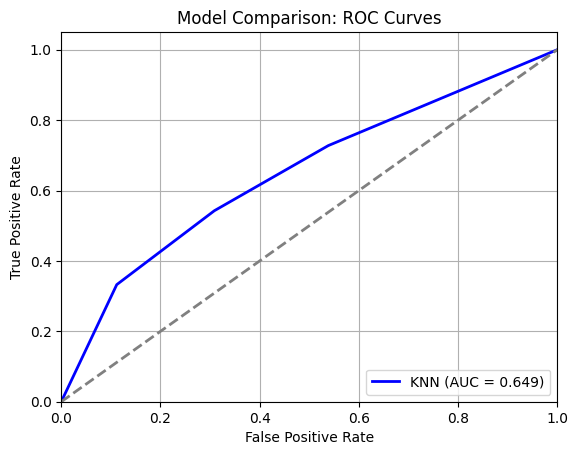

In [25]:
# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the model
knn.fit(X_train_df, y_train_df)

# Predict on the validation set
y_pred_val = knn.predict(X_valid_df)
y_proba_val = knn.predict_proba(X_valid_df)[:, 1]

# Calculate and print metrics
print(f"Validation AUROC: {roc_auc_score(y_valid_df, y_proba_val):.3f}")

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_valid_df, y_proba_val)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='KNN (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Comparison: ROC Curves')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Grid search

In [23]:
# KNN hyperparameter search
param_grid_knn = {
    "neighbors_range": [2, 3, 4, 5],
    "weights": ["uniform", "distance"],
}

for neighbors in param_grid_knn["neighbors_range"]:
    for weight in param_grid_knn["weights"]:
        # Start an MLflow run
        with mlflow.start_run(
            run_name=f"knn with {neighbors} neighbours, weight metric {weight}"
        ):
            knn = KNeighborsClassifier(
                n_neighbors=neighbors, weights="uniform", n_jobs=-1
            )
            knn.fit(X_train_df, y_train_df)

            y_train_proba = knn.predict_proba(X_train_df)[:, 1]  # Train probabilities
            y_val_proba = knn.predict_proba(X_valid_df)[:, 1]  # Val probabilities

            train_auroc = round(roc_auc_score(y_train_df, y_train_proba), 4)
            val_auroc = round(roc_auc_score(y_valid_df, y_val_proba), 4)
            auroc_gap = train_auroc - val_auroc

            mlflow.log_params(
                {
                    "n_neighbors": neighbors,
                    "weights": weight,
                }
            )

            mlflow.log_metrics(
                {
                    "train_auroc": train_auroc,
                    "validation_auroc": val_auroc,
                    "auroc_gap": auroc_gap,
                }
            )

            mlflow.sklearn.log_model(knn, "model")

            print(
                f"""
            Training AUROC:   {train_auroc:.4f}
            Validation AUROC: {val_auroc:.4f}
            AUROC Gap:        {auroc_gap:.4f}
            """
            )

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
2025/05/01 16:41:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



            Training AUROC:   0.9993
            Validation AUROC: 0.6393
            AUROC Gap:        0.3600
            


2025/05/01 16:41:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



            Training AUROC:   0.9993
            Validation AUROC: 0.6393
            AUROC Gap:        0.3600
            


2025/05/01 16:41:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



            Training AUROC:   0.9976
            Validation AUROC: 0.6494
            AUROC Gap:        0.3482
            


2025/05/01 16:41:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



            Training AUROC:   0.9976
            Validation AUROC: 0.6494
            AUROC Gap:        0.3482
            


2025/05/01 16:42:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



            Training AUROC:   0.9939
            Validation AUROC: 0.6536
            AUROC Gap:        0.3403
            


2025/05/01 16:42:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



            Training AUROC:   0.9939
            Validation AUROC: 0.6536
            AUROC Gap:        0.3403
            


2025/05/01 16:42:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



            Training AUROC:   0.9895
            Validation AUROC: 0.6637
            AUROC Gap:        0.3258
            


2025/05/01 16:42:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



            Training AUROC:   0.9895
            Validation AUROC: 0.6637
            AUROC Gap:        0.3258
            


# XGB + L1


In [26]:
# Start an MLflow run
with mlflow.start_run(
    run_name="Test run XGB Classifier with additional feature eng"
):
    # Log parameters
    mlflow.log_param("random_state", 42)
    mlflow.log_param("eval_metric", "auc")

    # Initialize and train the model
    model = xgb.XGBClassifier(
        random_state=42,
        eval_metric="auc",
        subsample=0.8,  # Minimise chance of overfitting
        colsample_bytree=0.8,  # Minimise chance of overfitting
        seed=42,
    )
    model.fit(
        X_train_df, y_train_df, eval_set=[(X_valid_df, y_valid_df)], verbose=True
    )

    # Log the model
    mlflow.xgboost.log_model(model, "model",)

    # Validate the model
    y_pred_val = model.predict(X_valid_df)
    y_proba_val = model.predict_proba(X_valid_df)[:, 1]

    # Log metrics
    mlflow.log_metric("validation_auroc", roc_auc_score(y_valid_df, y_proba_val))

    # Print classification report
    print(f"Validation AUROC: {roc_auc_score(y_valid_df, y_proba_val):.3f}")

[0]	validation_0-auc:0.71964
[1]	validation_0-auc:0.73313
[2]	validation_0-auc:0.74751
[3]	validation_0-auc:0.75792
[4]	validation_0-auc:0.76197
[5]	validation_0-auc:0.76398
[6]	validation_0-auc:0.76761
[7]	validation_0-auc:0.76405
[8]	validation_0-auc:0.76295
[9]	validation_0-auc:0.76209
[10]	validation_0-auc:0.76565
[11]	validation_0-auc:0.76631
[12]	validation_0-auc:0.76827
[13]	validation_0-auc:0.77100
[14]	validation_0-auc:0.76988
[15]	validation_0-auc:0.77033
[16]	validation_0-auc:0.77026
[17]	validation_0-auc:0.77026
[18]	validation_0-auc:0.77050
[19]	validation_0-auc:0.77012
[20]	validation_0-auc:0.77004
[21]	validation_0-auc:0.76877
[22]	validation_0-auc:0.76941
[23]	validation_0-auc:0.76763
[24]	validation_0-auc:0.76781
[25]	validation_0-auc:0.76650
[26]	validation_0-auc:0.76884
[27]	validation_0-auc:0.76865
[28]	validation_0-auc:0.76921
[29]	validation_0-auc:0.77113
[30]	validation_0-auc:0.77122
[31]	validation_0-auc:0.77130
[32]	validation_0-auc:0.77197
[33]	validation_0-au

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:46:13] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/01 16:46:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Validation AUROC: 0.773


## Grid search

In [27]:
# For grid search when doing more extensive testing
param_grid_xgb = {
    "learning_rate": [0.04, 0.07, 0.1],
    "alpha": [20, 40, 60, 80],
    "colsample_bytree": [0.70, 0.75],
    "subsample":[0.7,0.75],
}

In [28]:
# Nested for loops for manual grid search
for rowsample in param_grid_xgb["subsample"]:
    for learning_rate in param_grid_xgb["learning_rate"]:
        for alpha in param_grid_xgb["alpha"]:
            for colsample in param_grid_xgb["colsample_bytree"]:
                # Start an MLflow run
                with mlflow.start_run(
                    run_name=f"XGB_learning_rate_{learning_rate}_l1{alpha}_colsample_{colsample}_rowsample_{rowsample}"
                ):
                    # Log current parameters
                    mlflow.log_param("random_state", 42)
                    mlflow.log_param("eval_metric", "auc")
                    mlflow.log_param("subsample", rowsample)
                    mlflow.log_param("colsample_bytree", colsample)
                    mlflow.log_param("seed", 42)
                    mlflow.log_param("max_depth", 6)
                    mlflow.log_param("learning_rate", learning_rate)
                    mlflow.log_param("l1_alpha", alpha)

                    # Initialize and train the model
                    model = xgb.XGBClassifier(
                        random_state=42,
                        eval_metric="auc",
                        subsample=rowsample, # Sub set rows
                        colsample_bytree=colsample, # Sub set columns
                        seed=42,
                        max_depth=6,
                        alpha=alpha,
                        learning_rate=learning_rate,
                        verbosity=0,
                    )

                    # Train with evaluation on both sets
                    model.fit(
                        X_train_df,
                        y_train_df,
                        eval_set=[(X_train_df, y_train_df), (X_valid_df, y_valid_df)],
                        verbose=False,
                    )

                    # Get predictions for both sets
                    y_train_proba = model.predict_proba(X_train_df)[:, 1]
                    y_val_proba = model.predict_proba(X_valid_df)[:, 1]

                    # Calculate AUROCs
                    train_auroc = roc_auc_score(y_train_df, y_train_proba)
                    val_auroc = roc_auc_score(y_valid_df, y_val_proba)

                    # Log metrics to MLflow
                    mlflow.log_metric("train_auroc", round(train_auroc, 4))
                    mlflow.log_metric("validation_auroc", round(val_auroc, 4))
                    mlflow.log_metric("auroc_gap", round(train_auroc - val_auroc, 4))

                    # Log the model
                    mlflow.xgboost.log_model(model, "model")

                    # Print performance
                    print(f"\nModel with learning_rate_{learning_rate}_l1{alpha}_colsample_{colsample}_rowsample_{rowsample}")
                    print(f"Train AUROC: {train_auroc:.4f}")
                    print(f"Validation AUROC: {val_auroc:.4f}")
                    print(f"AUROC gap: {train_auroc - val_auroc:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:46:29] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/01 16:46:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model with learning_rate_0.04_l120_colsample_0.7_rowsample_0.7
Train AUROC: 0.9666
Validation AUROC: 0.7800
AUROC gap: 0.1867


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:46:43] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/01 16:46:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model with learning_rate_0.04_l120_colsample_0.75_rowsample_0.7
Train AUROC: 0.9670
Validation AUROC: 0.7812
AUROC gap: 0.1857


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:46:57] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/01 16:47:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model with learning_rate_0.04_l140_colsample_0.7_rowsample_0.7
Train AUROC: 0.9622
Validation AUROC: 0.7738
AUROC gap: 0.1884


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:10] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/01 16:47:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model with learning_rate_0.04_l140_colsample_0.75_rowsample_0.7
Train AUROC: 0.9624
Validation AUROC: 0.7745
AUROC gap: 0.1879


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/01 16:47:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model with learning_rate_0.04_l160_colsample_0.7_rowsample_0.7
Train AUROC: 0.9591
Validation AUROC: 0.7718
AUROC gap: 0.1873


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:36] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/01 16:47:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model with learning_rate_0.04_l160_colsample_0.75_rowsample_0.7
Train AUROC: 0.9595
Validation AUROC: 0.7722
AUROC gap: 0.1873


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:49] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/01 16:47:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model with learning_rate_0.04_l180_colsample_0.7_rowsample_0.7
Train AUROC: 0.9560
Validation AUROC: 0.7697
AUROC gap: 0.1864


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:48:03] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/01 16:48:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model with learning_rate_0.04_l180_colsample_0.75_rowsample_0.7
Train AUROC: 0.9568
Validation AUROC: 0.7708
AUROC gap: 0.1860


KeyboardInterrupt: 

# RF


## Grid search with RF

In [29]:
# For hyper params searching
param_grid_rf = {
    "max_depth": [4, 5, 6, 7],
    "min_samples_leaf": [4, 7, 10],
}

# Nested for loops for grid search
for max_depth in param_grid_rf["max_depth"]:
    for min_samples_leaf in param_grid_rf["min_samples_leaf"]:
        # Start an MLflow run
        with mlflow.start_run(
            run_name=f"RF_max_depth_{max_depth}_min_samples_leaf_{min_samples_leaf}"
        ):
            # Log current parameters
            mlflow.log_param("random_state", 42)
            mlflow.log_param("max_depth", max_depth)
            mlflow.log_param("min_samples_leaf", min_samples_leaf)

            # Initialize and train the model
            model = RandomForestClassifier(
                random_state=42,
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
            )
            model.fit(X_train_df, y_train_df)

            # Get predictions for both sets
            y_train_proba = model.predict_proba(X_train_df)[:, 1]
            y_val_proba = model.predict_proba(X_valid_df)[:, 1]

            # Calculate AUROCs
            train_auroc = roc_auc_score(y_train_df, y_train_proba)
            val_auroc = roc_auc_score(y_valid_df, y_val_proba)

            # Log metrics to MLflow
            mlflow.log_metric("train_auroc", round(train_auroc, 4))
            mlflow.log_metric("validation_auroc", round(val_auroc, 4))
            mlflow.log_metric("auroc_gap", round(train_auroc - val_auroc, 4))

            # Log the model
            mlflow.sklearn.log_model(model, "model")

            # Print performance
            print(
                f"Model with max_depth={max_depth}, min_samples_leaf={min_samples_leaf}"
            )
            print(f"Train AUROC: {train_auroc:.4f}")
            print(f"Validation AUROC: {val_auroc:.4f}")
            print(f"AUROC gap: {train_auroc - val_auroc:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2025/05/01 16:48:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model with max_depth=4, min_samples_leaf=4
Train AUROC: 0.9159
Validation AUROC: 0.7598
AUROC gap: 0.1561


2025/05/01 16:48:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model with max_depth=4, min_samples_leaf=7
Train AUROC: 0.9160
Validation AUROC: 0.7594
AUROC gap: 0.1565


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


KeyboardInterrupt: 

In [ ]:
model_rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_estimators=300,
    min_samples_split=10,
    min_samples_leaf=1,
    max_depth=20,
)

model_rf.fit(X_train_df, y_train_smote)
y_pred_val = model_rf.predict(X_valid_df)
y_proba_val = model_rf.predict_proba(X_valid_df)[:, 1]

print("Validation Metrics:")
print(f"Validation AUROC: {roc_auc_score(y_valid_df, y_proba_val):.3f}")

# EBM


In [ ]:
# Global feature importance
ebm_global = ebm.explain_global()
mlflow.log_text(str(ebm_global), "global_feature_importance.txt")

# for feat in ebm_global.data()[:5]:
#     print(f"{feat['name']}: {feat['scores'][0]:.4f}")



In [ ]:
show(ebm_global)  # Interactive visualization

In [ ]:
show(ebm.explain_local(X_valid_df[:10], y_valid_df[:10]), 0)


In [ ]:
ebm_perf = ROC(ebm).explain_perf(X_valid_df, y_valid_df, name='EBM')
show(ebm_perf)


## Grid search


In [ ]:
param_grid_ebm = {
    "learning_rate":[0.01, 0.015, 0.02],
    "min_samples_leaf":[3, 4, 5],
}

# Start MLflow parent run
for lr in param_grid_ebm["learning_rate"]:
    for min_leaf in param_grid_ebm["min_samples_leaf"]:
        # Nested child run for each combination
        with mlflow.start_run(run_name=f"EBM_lr_{lr}_leaf_{min_leaf}"):
            # Initialize EBM
            ebm = ExplainableBoostingClassifier(
                learning_rate=lr,
                min_samples_leaf=min_leaf,
                interactions=10,
                outer_bags=8,
                random_state=42,
                n_jobs=-1
            )

            # Train
            ebm.fit(X_train_df, y_train_df)

            # Predictions
            y_train_proba = ebm.predict_proba(X_train_df)[:, 1]
            y_val_proba = ebm.predict_proba(X_valid_df)[:, 1]

            # Metrics
            train_auroc = roc_auc_score(y_train_df, y_train_proba)
            val_auroc = roc_auc_score(y_valid_df, y_val_proba)
            auroc_gap = train_auroc - val_auroc

            # MLflow logging
            mlflow.log_params({
                "learning_rate": lr,
                "min_samples_leaf": min_leaf,
                "interactions": 10,
                "outer_bags": 8
            })

            mlflow.log_metrics({
                "train_auroc": train_auroc,
                "validation_auroc": val_auroc,
                "auroc_gap": auroc_gap
            })

            # Console output
            print(f"\n=== lr: {lr}, min_leaf: {min_leaf} ===")
            print(f"Train AUROC: {train_auroc:.4f}")
            print(f"Val AUROC:   {val_auroc:.4f}")
            print(f"AUROC Gap:   {auroc_gap:.4f}")

            mlflow.end_run()



# Linear SVM

## Grid search

In [ ]:
# Hyperparameter grid
param_grid = {
    "C": [0.1, 1, 10],
}

# Start MLflow parent run
for C in param_grid["C"]:
    # Start nested run for each combination
    with mlflow.start_run(
        run_name=f"SVM_C_{C}_kernel_linear",
    ):
        # Initialize SVM
        svm = SVC(
            C=C,
            kernel="linear",
            probability=True,
            random_state=42,
            cache_size=1000,
        )

        # Train
        svm.fit(X_train_df, y_train_df)

        # Predictions
        y_train_proba = svm.predict_proba(X_train_df)[:, 1]
        y_val_proba = svm.predict_proba(X_valid_df)[:, 1]

        # Metrics
        train_auroc = roc_auc_score(y_train_df, y_train_proba)
        val_auroc = roc_auc_score(y_valid_df, y_val_proba)
        auroc_gap = train_auroc - val_auroc

        # MLflow logging
        mlflow.log_params(
            {
                "C": C,
                "kernel": "linear",
            }
        )

        mlflow.log_metrics(
            {
                "train_auroc": train_auroc,
                "val_auroc": val_auroc,
                "auroc_gap": auroc_gap,
            }
        )

        # Console output
        print(f"\n=== C: {C}, kernel: linear ===")
        print(f"train_auroc: {train_auroc:.4f}")
        print(f"validation_auroc:   {val_auroc:.4f}")
        print(f"auroc_gap:   {auroc_gap:.4f}")

# RBF SVM

## Grid search

In [ ]:
# Hyperparameter grid
param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", "auto", 0.01],
}

# Start MLflow parent run
for C in param_grid["C"]:
    for gamma in param_grid["gamma"]:
        # Start nested run for each combination
        with mlflow.start_run(
            run_name=f"SVM_C_{C}_kernel_rbf_gamma_{gamma}",
        ):
            # Initialize SVM
            svm = SVC(
                C=C,
                kernel="rbf",
                gamma=gamma,
                probability=True,
                random_state=42,
                cache_size=1000,
            )

            # Train
            svm.fit(X_train_df, y_train_df)

            # Predictions
            y_train_proba = svm.predict_proba(X_train_df)[:, 1]
            y_val_proba = svm.predict_proba(X_valid_df)[:, 1]

            # Metrics
            train_auroc = roc_auc_score(y_train_df, y_train_proba)
            val_auroc = roc_auc_score(y_valid_df, y_val_proba)
            auroc_gap = train_auroc - val_auroc

            # MLflow logging
            mlflow.log_params(
                {
                    "C": C,
                    "kernel": "rbf",
                    "gamma": gamma,
                }
            )

            mlflow.log_metrics(
                {
                    "train_auroc": train_auroc,
                    "val_auroc": val_auroc,
                    "auroc_gap": auroc_gap,
                }
            )

            # Console output
            print(f"\n=== C: {C}, kernel: rbf, gamma: {gamma} ===")
            print(f"train_auroc: {train_auroc:.4f}")
            print(f"validation_auroc:   {val_auroc:.4f}")
            print(f"auroc_gap:   {auroc_gap:.4f}")

# Summary

Analysis of best performing models from each algorithm (retrieving from MLflow experiment tracker)

In [2]:
# Logistic regression with L1
best_lr = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=10,
    tol=1e-3,
    max_iter=1500,
    n_jobs=-1,
    random_state=42,
)
best_lr.fit(X_train_df, y_train_df)
lr_y_val_proba = best_lr.predict_proba(X_valid_df)[:, 1]
lr_val_auroc = round(roc_auc_score(y_valid_df, lr_y_val_proba), 4)
print(lr_val_auroc)

NameError: name 'LogisticRegression' is not defined

In [34]:
# K-nearest neighbours
best_knn = KNeighborsClassifier(n_neighbors=5, weights="distance", n_jobs=-1)
best_knn.fit(X_train_df, y_train_df)
knn_y_val_proba = best_knn.predict_proba(X_valid_df)[:, 1]
knn_val_auroc = round(roc_auc_score(y_valid_df, knn_y_val_proba), 4)
print(knn_val_auroc)

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Reference (AUC = 0.500)')

# Customize plot appearance
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, labelpad=10)
plt.ylabel('True Positive Rate', fontsize=14, labelpad=10)
plt.title('Model Comparison: ROC Curves', fontsize=16, pad=20)
plt.legend(loc='lower right', frameon=True, fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.663


In [35]:
# XGB
best_xgb = xgb.XGBClassifier(
    random_state=42,
    eval_metric="auc",
    subsample=0.8,
    colsample_bytree=0.8,
    seed=42,
    max_depth=7,
    alpha=10,
    learning_rate=0.05,
    verbosity=0,
)

best_xgb.fit(X_train_df, y_train_df)
xgb_y_val_proba = best_xgb.predict_proba(X_valid_df)[:, 1]
xgb_val_auroc = round(roc_auc_score(y_valid_df, xgb_y_val_proba), 4)
print(xgb_val_auroc)

0.7848


In [ ]:
# Random Forest
best_rf = RandomForestClassifier(
    random_state=42,
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=5,
)
best_rf.fit(X_train_df, y_train_df)
rf_y_val_proba = best_rf.predict_proba(X_valid_df)[:, 1]
rf_val_auroc = round(roc_auc_score(y_valid_df, rf_y_val_proba), 4)
print(rf_val_auroc)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.7918


In [ ]:
# Explainable Boosting Machine (EBM)
best_ebm = ExplainableBoostingClassifier(
    learning_rate=0.01,
    min_samples_leaf=5,
    interactions=10,
    outer_bags=8,
    random_state=42,
    n_jobs=-1,
)

best_ebm.fit(X_train_df, y_train_df)
ebm_y_val_proba = best_ebm.predict_proba(X_valid_df)[:, 1]
ebm_val_auroc = round(roc_auc_score(y_valid_df, ebm_y_val_proba), 4)
print(ebm_val_auroc)

0.7698


In [ ]:
# Support Vector Machine
best_svm = SVC(
    C=1,
    kernel="rbf",
    gamma=0.01,
    probability=True,
    random_state=42,
    cache_size=1000,
)

best_svm.fit(X_train_df, y_train_df)
svm_y_val_proba = best_svm.predict_proba(X_valid_df)[:, 1]
svm_val_auroc = round(roc_auc_score(y_valid_df, svm_y_val_proba), 4)
print(svm_val_auroc)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7612


In [ ]:
# Linear Support Vector Machine
best_linear_svm = SVC(
    C=1,
    kernel="linear",
    probability=True,
    random_state=42,
    cache_size=1000,
)

best_linear_svm.fit(X_train_df, y_train_df)
linear_svm_y_val_proba = best_linear_svm.predict_proba(X_valid_df)[:, 1]
linear_svm_val_auroc = round(roc_auc_score(y_valid_df, linear_svm_y_val_proba), 4)
print(linear_svm_val_auroc)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.7535


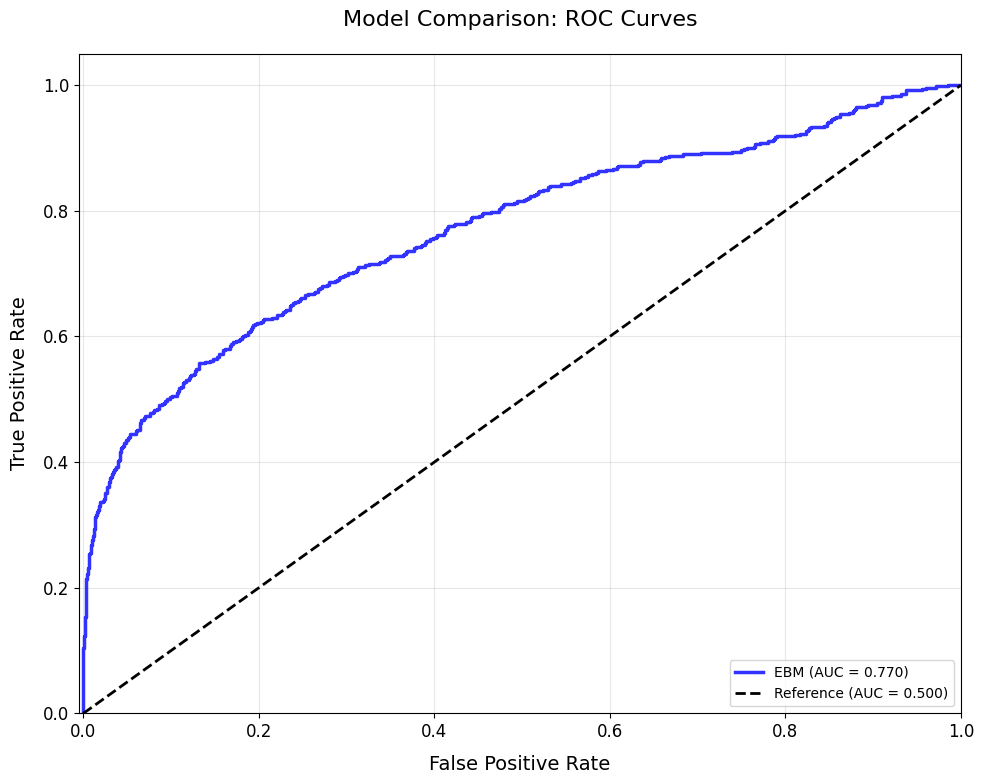

In [ ]:
model_names = ["EBM"]
aurocs = [ebm_val_auroc]
model_predictions = [
    ebm_y_val_proba,
]

# aurocs
plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 12

# Define colors for each model
colors = ['blue']

# Plot ROC curves for each model
for i, (name, auroc) in enumerate(zip(model_names, aurocs)):
    # Get model predictions
    y_proba = model_predictions[i]

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_valid_df, y_proba)

    # Plot curve with custom styling
    plt.plot(fpr, tpr,
             color=colors[i],
             lw=2.5,
             alpha=0.8,
             label=f'{name} (AUC = {auroc:.3f})')

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Reference (AUC = 0.500)')

# Customize plot appearance
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, labelpad=10)
plt.ylabel('True Positive Rate', fontsize=14, labelpad=10)
plt.title('Model Comparison: ROC Curves', fontsize=16, pad=20)
plt.legend(loc='lower right', frameon=True, fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

## AUROC chart

In [1]:
model_names = ["Random Forest", "XGBoost", "EBM", "SVM", "Logistic Regression", "KNN",]
aurocs = [ rf_val_auroc, xgb_val_auroc,ebm_val_auroc, svm_val_auroc, lr_val_auroc, knn_val_auroc,]
model_predictions = [
    rf_y_val_proba,
    xgb_y_val_proba,
    ebm_y_val_proba,
    svm_y_val_proba,
    lr_y_val_proba,
    knn_y_val_proba,
]

# aurocs
plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 12

# Define colors for each model
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Plot ROC curves for each model
for i, (name, auroc) in enumerate(zip(model_names, aurocs)):
    # Get model predictions
    y_proba = model_predictions[i]

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_valid_df, y_proba)

    # Plot curve with custom styling
    plt.plot(fpr, tpr,
             color=colors[i],
             lw=2.5,
             alpha=0.8,
             label=f'{name} (AUC = {auroc:.3f})')

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Reference (AUC = 0.500)')

# Customize plot appearance
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, labelpad=10)
plt.ylabel('True Positive Rate', fontsize=14, labelpad=10)
plt.title('Model Comparison: ROC Curves', fontsize=16, pad=20)
plt.legend(loc='lower right', frameon=True, fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

NameError: name 'rf_val_auroc' is not defined

## Feature Importance

Top Important Features:
ethnicity_6.0: 0.8273880048222099
LabLast_Lactate Blood: -0.6147239989582615
LabMean_Lactate Blood: -0.5469442009959509
LabLast_pO2 Blood: -0.4867128086593476
LabLast_pH Blood: -0.4171614619785987
LabMean_pCO2 Blood: -0.31154898132646713
len_stay: -0.2908194213359382
age: 0.2626682637556062
LabMean_pH Blood: -0.24763270223380282
LabMean_Lymphocytes Pleural: -0.23561256108362005


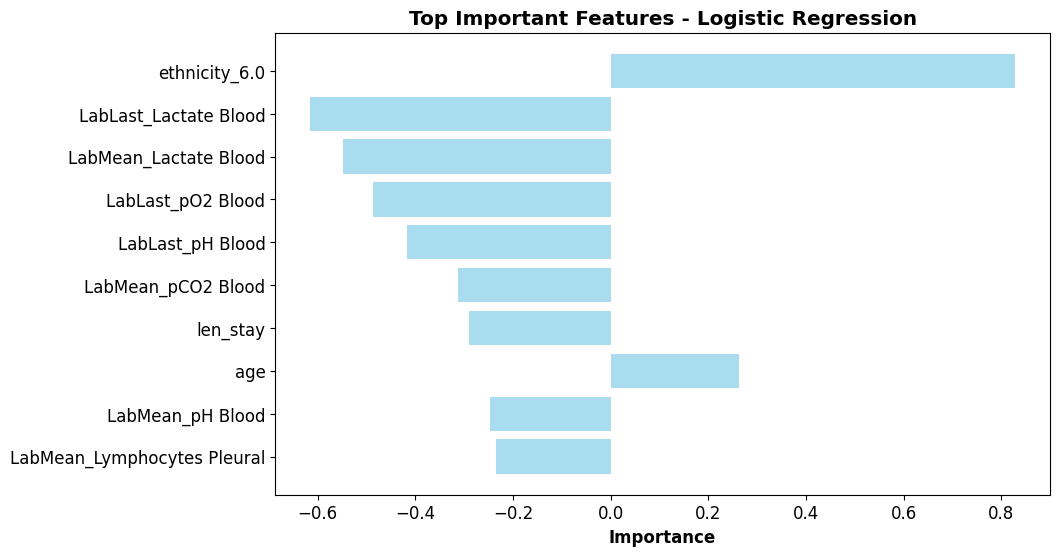

In [ ]:
# Logistic Regression
if hasattr(best_lr, "coef_"):
    importance = dict(zip(X_train_df.columns, best_lr.coef_[0]))

    sorted_importance = sorted(importance.items(), key=lambda x: abs(x[1]), reverse=True)

    #Select the top 10 features
    top_n = 10
    top_features = sorted_importance[:top_n]
    features, values = zip(*top_features)

    print("Top Important Features:")
    for feature, importance_value in sorted_importance[:top_n]:
        print(f"{feature}: {importance_value}")

    #visualization
    plt.figure(figsize=(10, 6))
    plt.barh(features, values, color='skyblue', alpha=0.7)
    plt.xlabel('Importance', fontweight='bold')
    plt.title('Top Important Features - Logistic Regression', fontweight='bold',)
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
# XGB
xgb_importance_df = pd.DataFrame({
    'feature': X_train_df.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print("Top 10 Features:")
print(xgb_importance_df)

plt.figure(figsize=(10, 6))

# Create horizontal bars
bars = plt.barh(
    xgb_importance_df['feature'][::-1],  # Reverse for highest at top
    xgb_importance_df['importance'][::-1],
    color='skyblue',
    alpha=0.7
)

# Formatting
plt.xlabel('Feature Importance (Gain)', fontweight='bold')
plt.title('Top 10 XGBoost Feature Importances', fontweight='bold', pad=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

plt.show()

In [ ]:
# RF
rf_importance_df = pd.DataFrame({
    'feature': X_train_df.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print("Top 10 Features:")
print(rf_importance_df)

plt.figure(figsize=(10, 6))

# Create horizontal bars
bars = plt.barh(
    rf_importance_df['feature'][::-1],  # Reverse for highest at top
    rf_importance_df['importance'][::-1],
    color="skyblue",
    alpha=0.7
)

# Formatting
plt.xlabel('Feature Importance (Gain)', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.title('Top 10 Random Forest Feature Importances', fontweight='bold', pad=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

plt.show()

In [ ]:
# EBM
ebm_global = best_ebm.explain_global()
show(ebm_global)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
show(best_ebm.explain_local(X_valid_df[:10], y_valid_df[:10]), 0)


## Ensembles

### Stacking ensemble (Meta-model)

In [ ]:
# Get training predictions for stacking
stack_X_train = np.column_stack([
    best_rf.predict_proba(X_train_df)[:, 1],
    best_xgb.predict_proba(X_train_df)[:, 1],
    best_ebm.predict_proba(X_train_df)[:, 1]
])

# Train meta-model (logistic regression)
stacker = LogisticRegression()
stacker.fit(stack_X_train, y_train_df)

# Validate on stacked predictions
stack_X_val = np.column_stack([rf_y_val_proba, xgb_y_val_proba, ebm_y_val_proba])
stacked_proba = stacker.predict_proba(stack_X_val)[:, 1]
stacked_auc = roc_auc_score(y_valid_df, stacked_proba)

print("=== Stacked Ensemble ===")
print(f"Validation AUROC: {stacked_auc:.4f}")

### Hard majority vote ensemble

In [ ]:
from sklearn.ensemble import VotingClassifier

# Create voting ensemble
hard_voting_clf = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('ebm', best_ebm)
    ],
    voting='hard'  # Majority vote of predicted classes
)

# Fit on training data
hard_voting_clf.fit(X_train_df, y_train_df)

# Predict on validation
y_val_pred = hard_voting_clf.predict(X_valid_df)

# Evaluate
hard_voting_auc = roc_auc_score(y_valid_df, y_val_pred)

print("=== Hard Majority Vote Ensemble ===")
print(f"Validation AUROC: {hard_voting_auc:.4f}")

In [ ]:
soft_voting_clf = VotingClassifier(
    estimators=[('rf', best_rf), ('xgb', best_xgb), ('ebm', best_ebm)],
    voting='soft',
    weights=[rf_val_auroc, xgb_val_auroc, ebm_val_auroc]
)

# Fit on training data
soft_voting_clf.fit(X_train_df, y_train_df)

# Predict on validation
y_val_pred = soft_voting_clf.predict(X_valid_df)
soft_voting_proba = soft_voting_clf.predict_proba(X_valid_df)[:, 1]

# Evaluate
soft_voting_val_auc = roc_auc_score(y_valid_df, soft_voting_proba)  # Note: Requires voting='soft' for probabilities

print("=== Soft Majority Vote Ensemble ===")
print(f"Validation AUROC: {soft_voting_val_auc:.4f}")

In [ ]:
model_names = ["Random Forest", "Soft Voting", "Stacked Ensemble","XGBoost","EBM"]
aurocs = [ rf_val_auroc, soft_voting_val_auc, stacked_auc, xgb_val_auroc, ebm_val_auroc]
model_predictions = [
    rf_y_val_proba,
    soft_voting_proba,
    stacked_proba,
    xgb_y_val_proba,
    ebm_y_val_proba,
]

# aurocs
plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 12

# Define colors for each model
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']


# Plot ROC curves for each model
for i, (name, auroc) in enumerate(zip(model_names, aurocs)):
    # Get model predictions
    y_proba = model_predictions[i]

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_valid_df, y_proba)

    # Plot curve with custom styling
    plt.plot(fpr, tpr,
             color=colors[i],
             lw=2.5,
             alpha=0.8,
             label=f'{name} (AUC = {auroc:.3f})')

# Add diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Reference (AUC = 0.500)')

# Customize plot appearance
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, labelpad=10)
plt.ylabel('True Positive Rate', fontsize=14, labelpad=10)
plt.title('Model Comparison: ROC Curves (Top 3 models & Ensembles)', fontsize=16, pad=20)
plt.legend(loc='lower right', frameon=True, fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

## Final Model Selected

We decided to go with Random Forest Classifier as our final model selected due to these considerations:


- Highest AUROC

- Computationally faster compared to other similar performing algorithms is helpful for deploying model as part of a bigger analytics tool

- Retains some form of interpretability but might not be as in-depth as EBM

In [ ]:
# Random Forest
best_rf = RandomForestClassifier(
    random_state=42,
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=5,
)
best_rf.fit(X_train_df, y_train_df)
rf_y_val_proba = best_rf.predict_proba(X_valid_df)[:, 1]
rf_val_auroc = round(roc_auc_score(y_valid_df, rf_y_val_proba), 4)
print(rf_val_auroc)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.7918


In [ ]:
# Make prediction with X_test
rf_y_test_proba = best_rf.predict_proba(X_test_df)[:, 1]
len(rf_y_test_proba)



2741

In [ ]:
# Create output DataFrame
results_df = pd.DataFrame({
    'patient_id': test_df['id'].unique(),
    'readmission_probability': rf_y_test_proba
})

# Save to CSV if needed
results_df.to_csv(project_directory+'/submission.csv', index=False)